In [1]:
from spacerocks.spacerock import SpaceRock
from spacerocks.simulation import Simulation
from spacerocks.units import Units

from astropy import units as u
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from itertools import groupby

def has_adjacent_empty_cells(vec):
    return np.any(vec * np.roll(vec, 1))

def longest_contiguous_segment_1d(vec, target=True):
    return max(sum(g) for k, g in groupby(vec) if k == target)

def compute_longest_streak(mask, target=True):
    longest_duration = 0
    for row in mask.T:
        if has_adjacent_empty_cells(row):
            duration = longest_contiguous_segment_1d(row, target=target)
            if duration > longest_duration:
                longest_duration = duration
    return longest_duration

def number_of_segments(vec, target=True):
    return len([sum(g) for k, g in groupby(vec) if k == True])

### Generate a bunch of rocks

In [2]:
units = Units()
units.timescale = 'tdb'
units.mass = u.M_sun

N = 250

rocks = SpaceRock(a=np.random.uniform(5.0, 5.4, N), 
                  e=np.random.uniform(0, 0.4, N), 
                  inc=np.random.uniform(0, 60, N), 
                  varpi=np.random.uniform(0, 360, N), 
                  node=np.random.uniform(0, 360, N), 
                  M=np.random.uniform(0, 360, N))

### Do the integration

The callback function removes particles with semimajor axis inconsistent with being trojans

In [3]:
def callback(sim):
    for n in sim.remaining_testparticles:
        try:
            p = sim.particles[n]
        except Exception:
            sim.remaining_testparticles = np.delete(sim.remaining_testparticles, 
                                                    np.where(sim.remaining_testparticles == n))
            
        if (p.a < 5.0) or (p.a > 5.4):
            sim.remove(hash=n)
            sim.remaining_testparticles = np.delete(sim.remaining_testparticles, 
                                                    np.where(sim.remaining_testparticles == n))

sim = Simulation(model='PLANETS', epoch='14 June 2022', units=units)
sim.add_spacerocks(rocks)
sim.integrator = 'whfast'
sim.dt = 10

t0 = sim.epoch.tdb.jd[0]
tf = t0 + 1_000_000 * 365.25
epochs = np.arange(t0, tf, 10 * 365.25)

prop, planets, sim = sim.propagate(epochs=epochs, units=units, callback=callback)

/Users/kjnapier/anaconda3/envs/kev/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets"
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

### Check if there are coorbitals

In [4]:
planet = planets[planets.name == 'Jupiter Barycenter']

In [5]:
trojans = {}
horseshoes = {}
for name in sim.remaining_testparticles:
    
    clone = prop[prop.name == name]   
    phi = (clone.mean_longitude.deg - planet.mean_longitude.deg) % 360
    
    t = (clone.epoch.jd - clone.epoch.jd.min()) / 365.25e6
    tbins = 30
    
    counts, _, _ = np.histogram2d(t, phi, range=[[t.min(), t.max()], [0, 360]], bins=(tbins, 30))
    mask = counts == 0
    streak = compute_longest_streak(mask)
    
    if streak == tbins:
        if phi.max() - phi.min() > 180:
            horseshoes[name] = clone
        else:
            trojans[name] = clone

/var/folders/9h/q88gd1wx28qdbp_qgt4zx4y40000gs/T/ipykernel_30385/4282189028.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(12, 4))


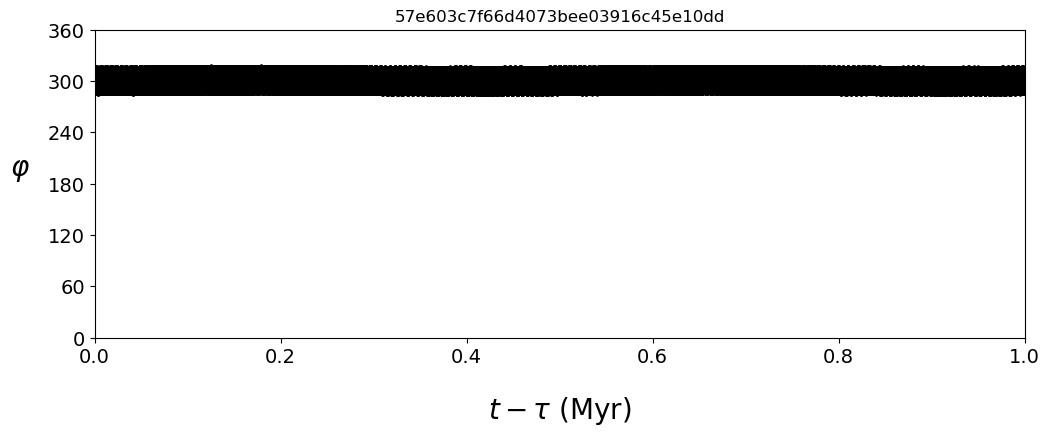

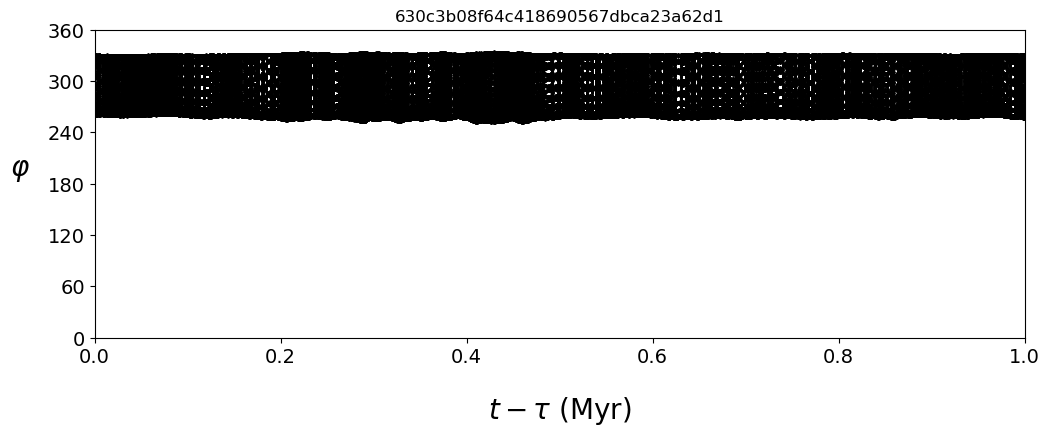

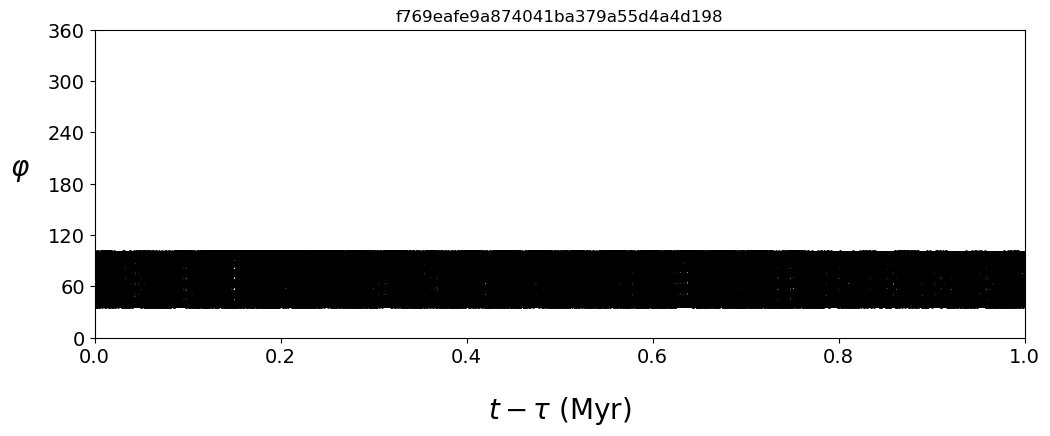

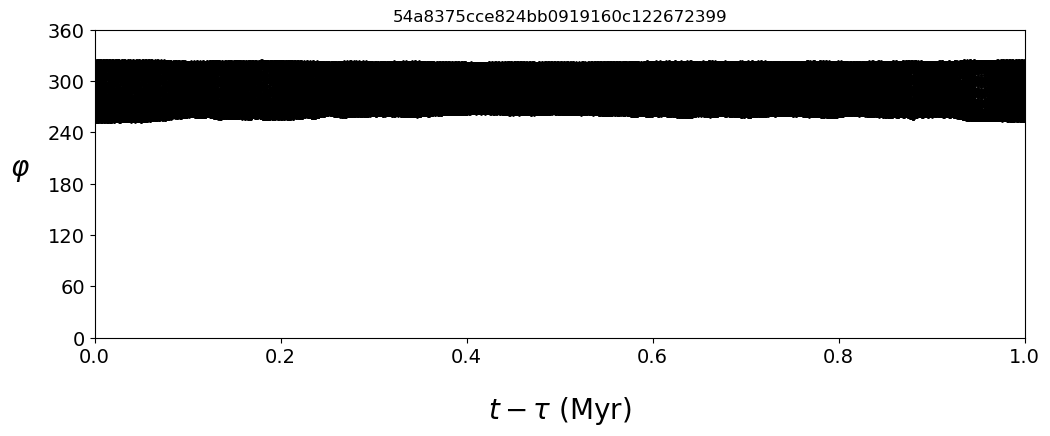

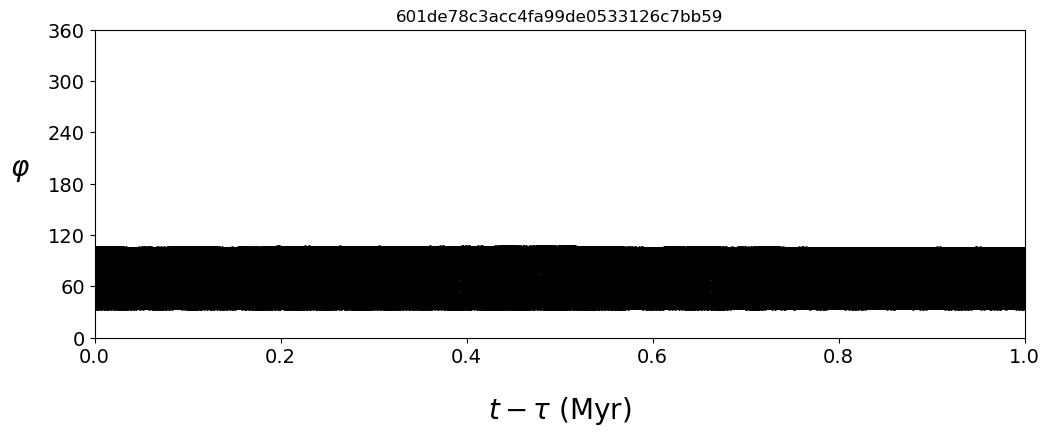

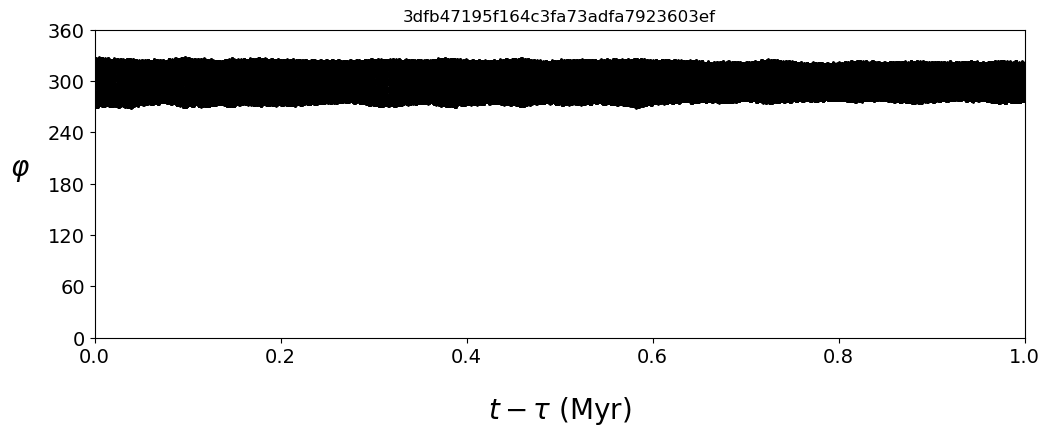

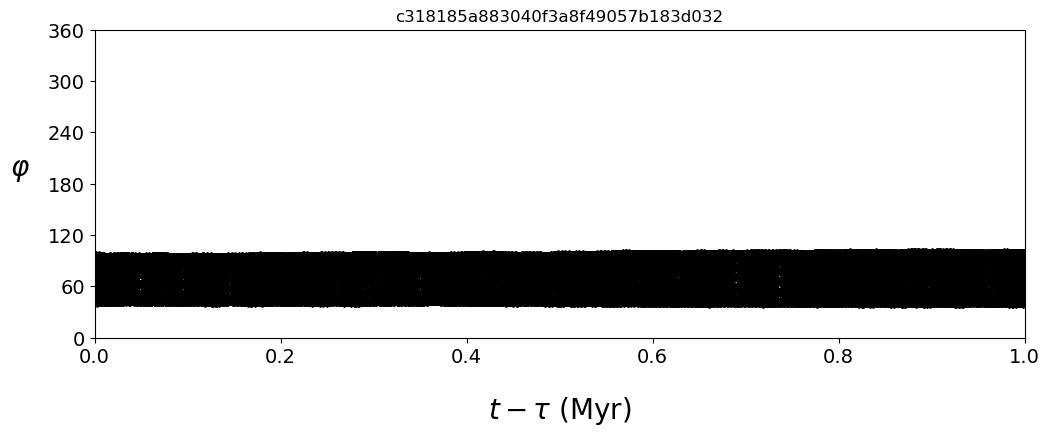

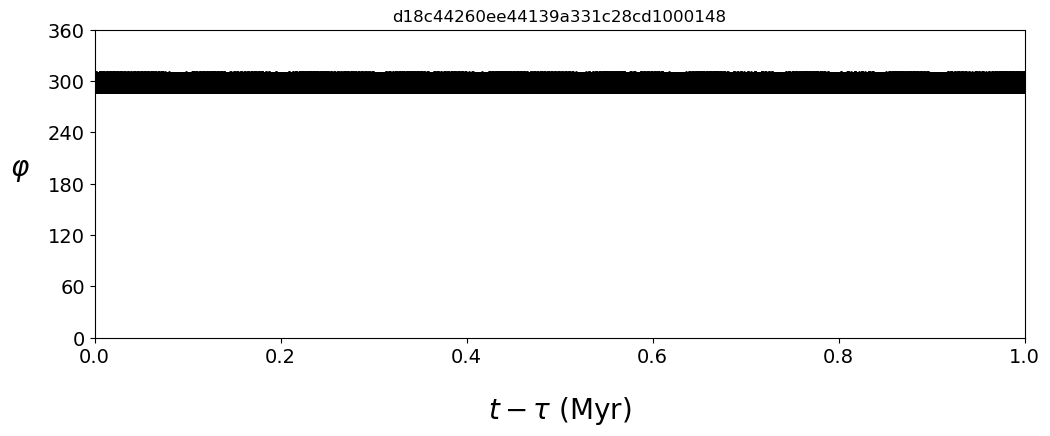

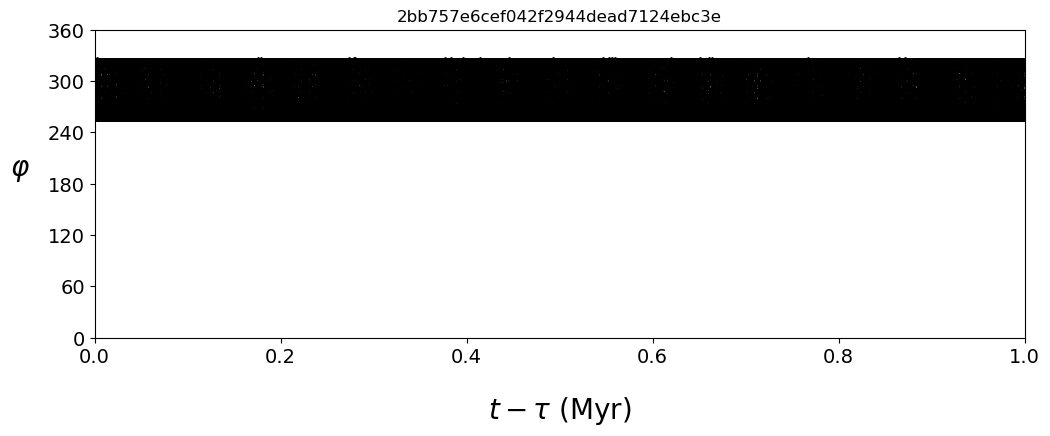

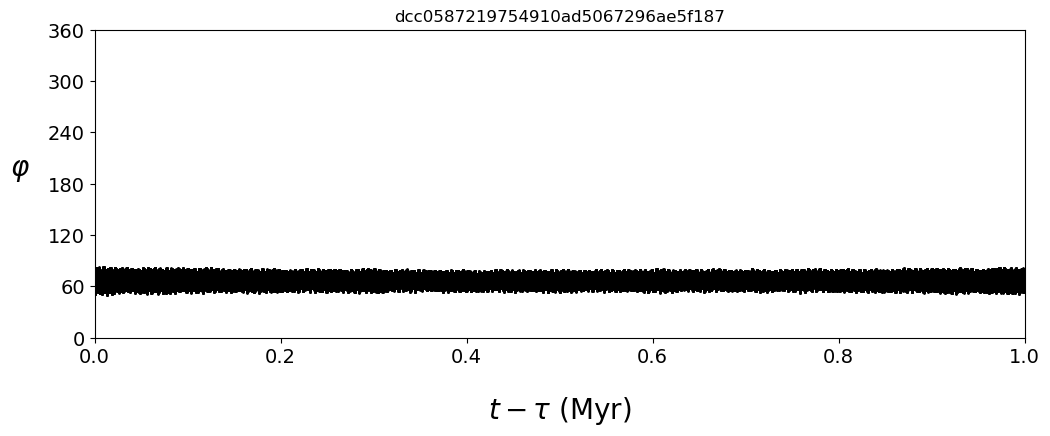

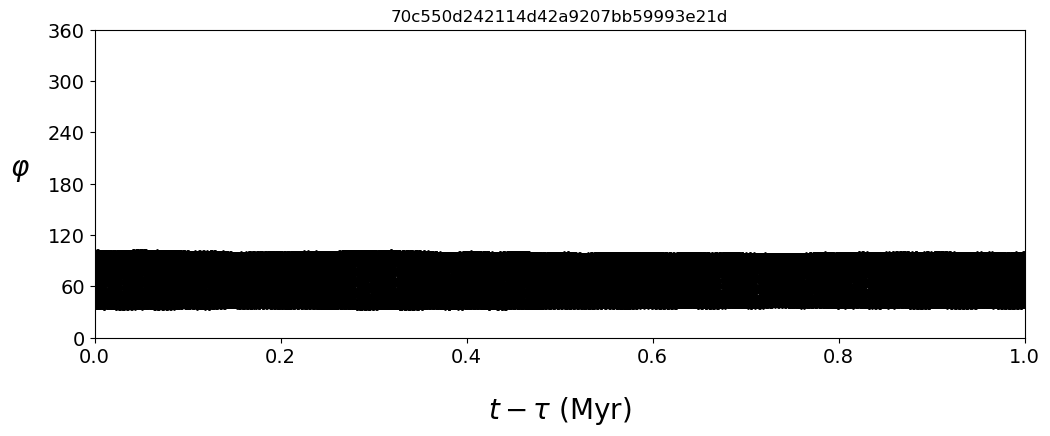

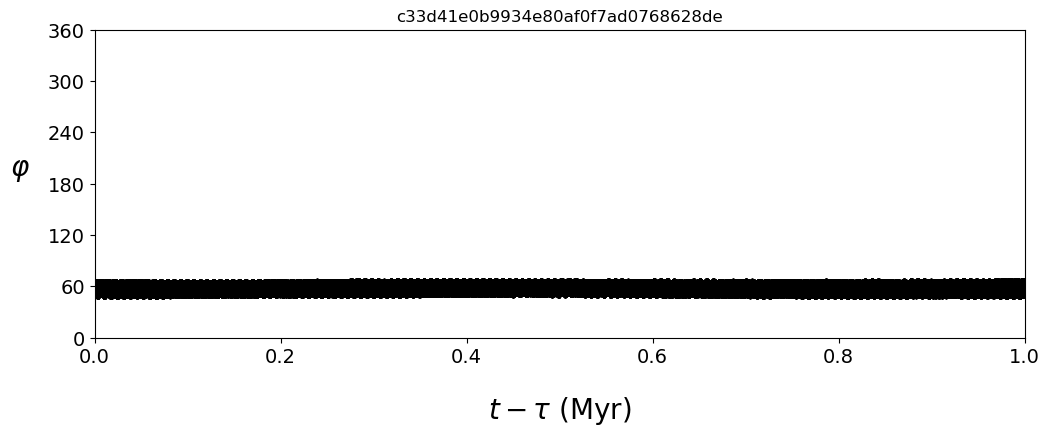

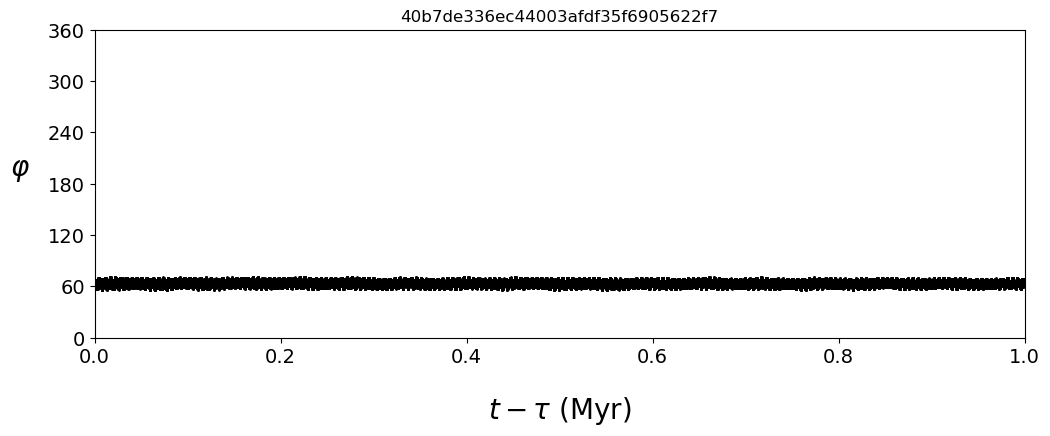

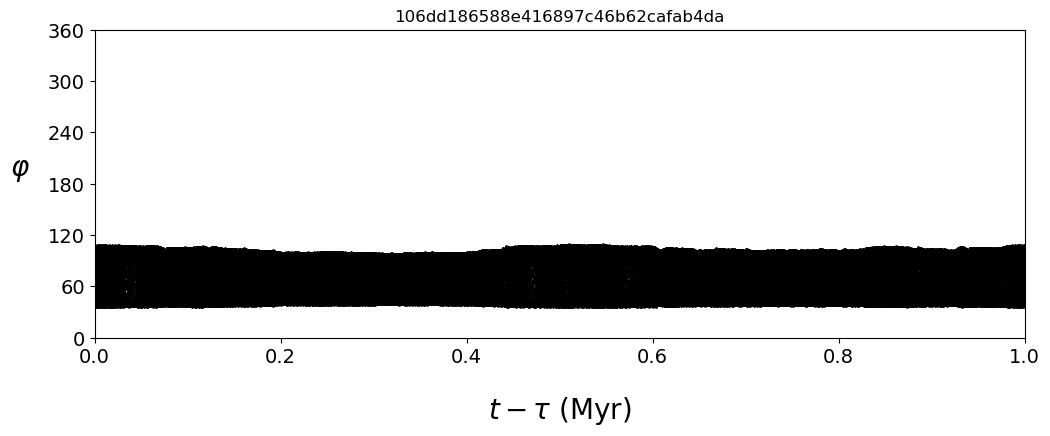

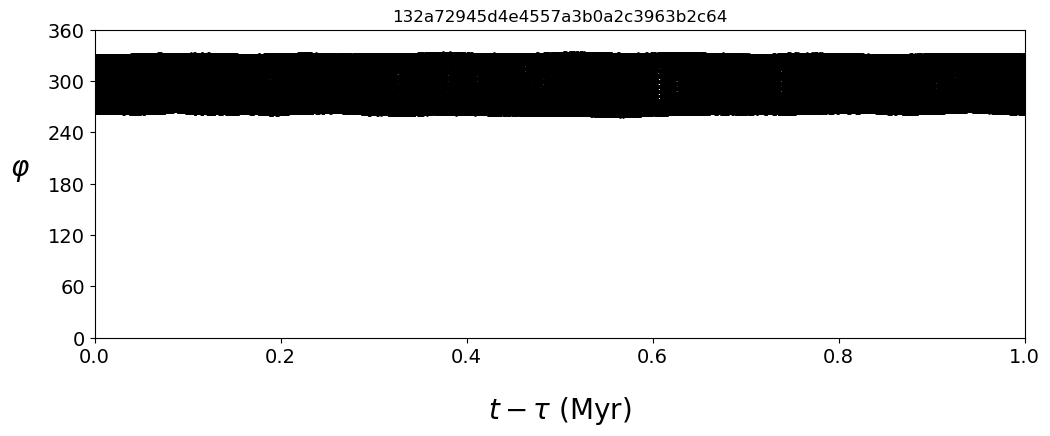

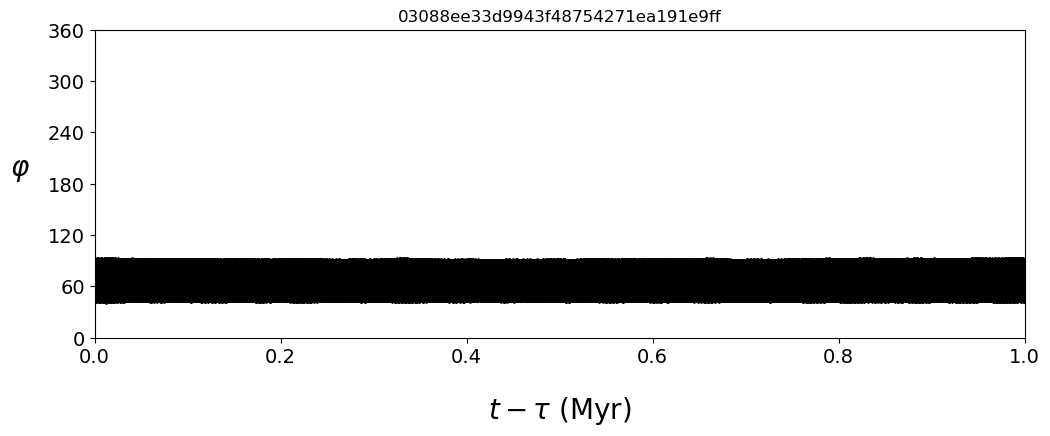

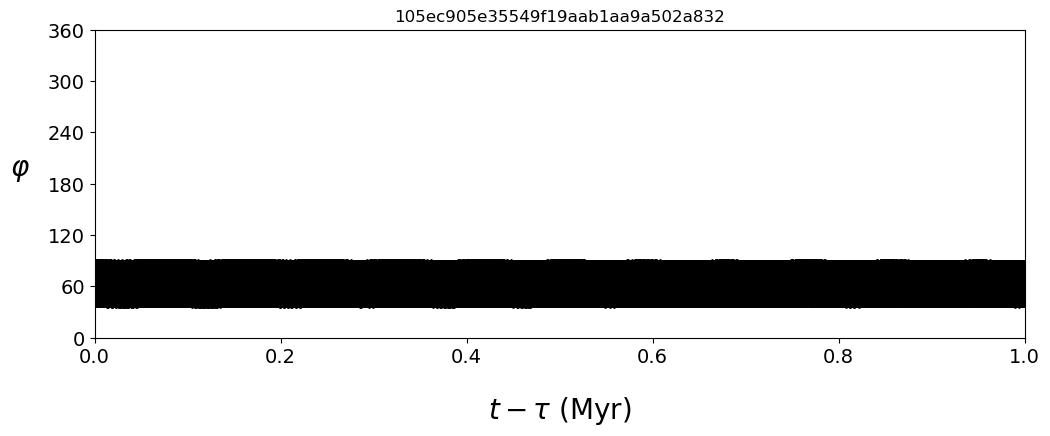

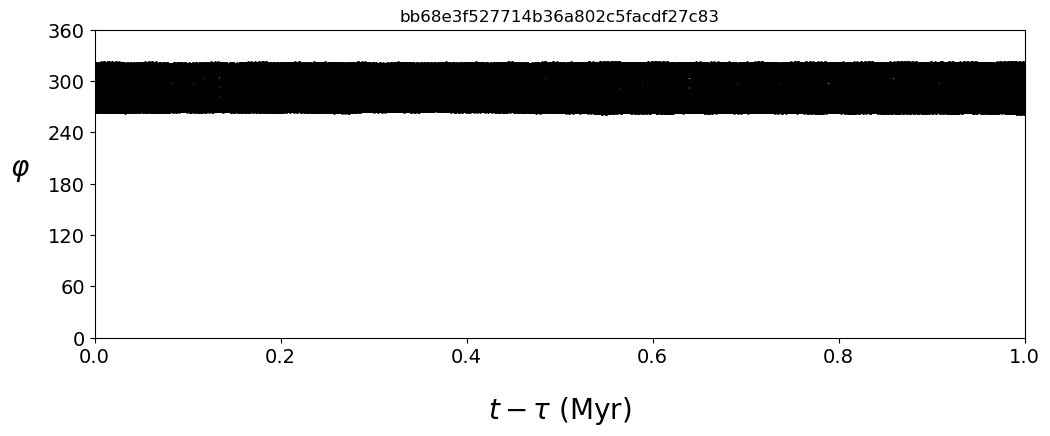

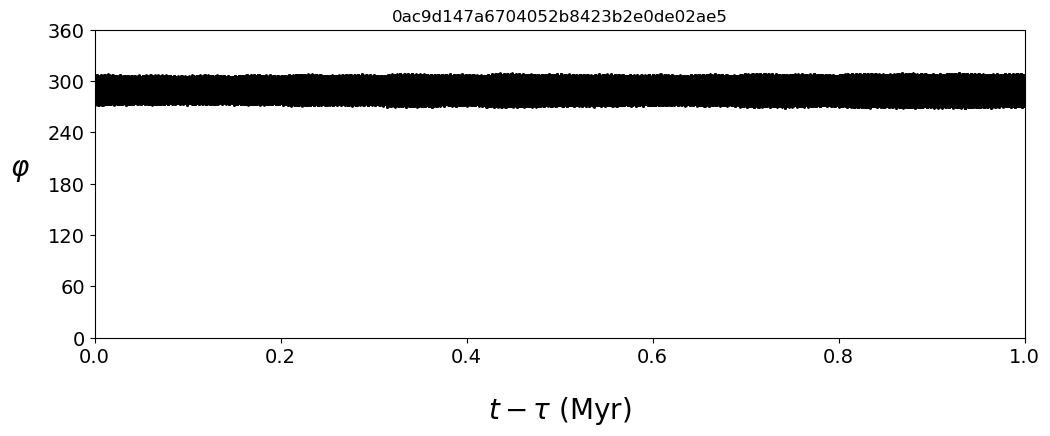

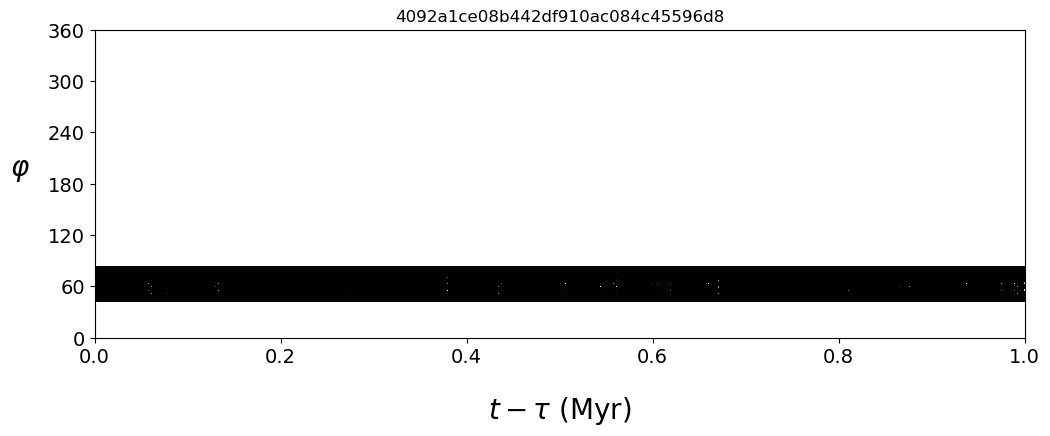

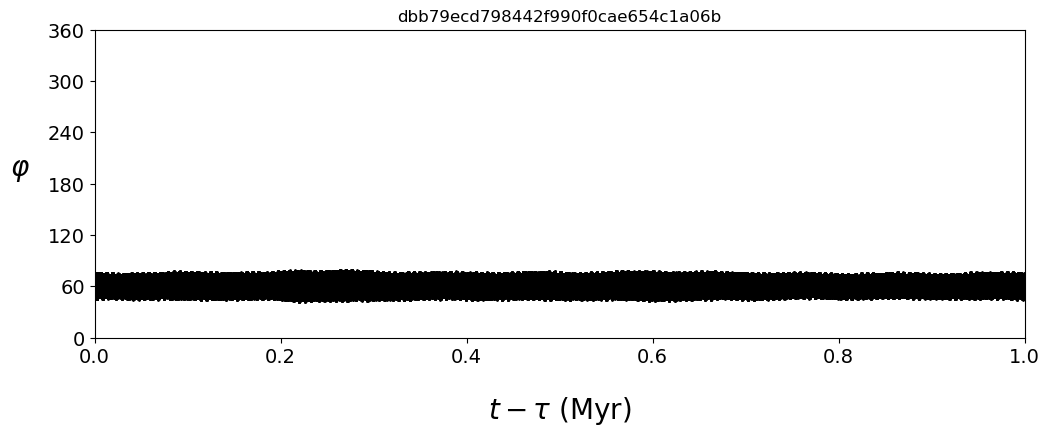

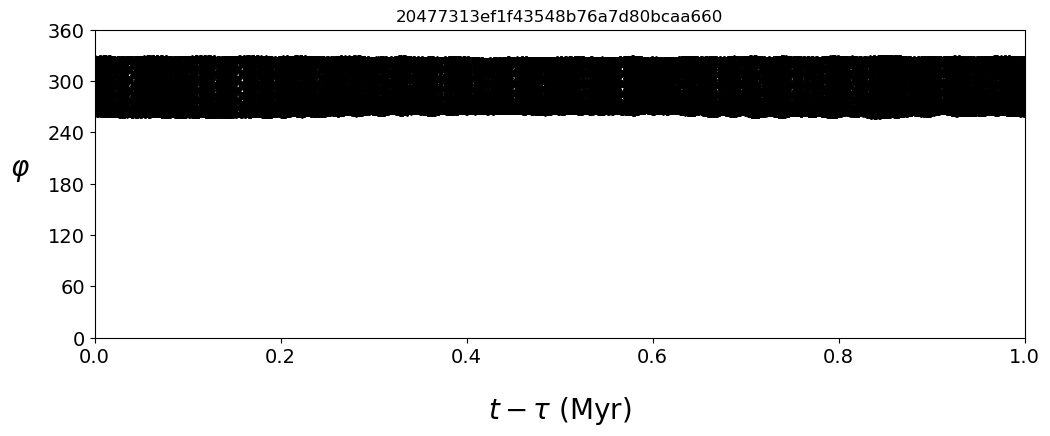

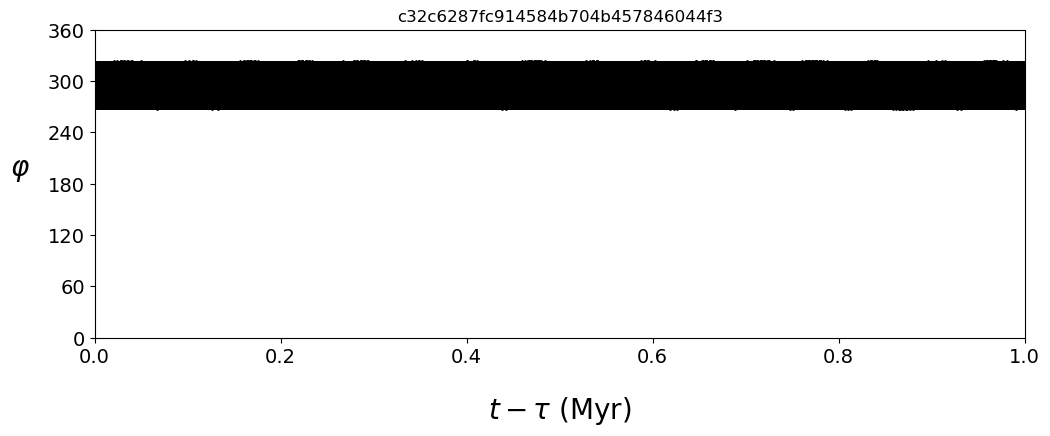

In [6]:
for name, rock in (trojans | horseshoes).items():
    t = (rock.epoch.jd - rock.epoch.jd.min()) / 365.25e6
    phi = (rock.mean_longitude.deg - planet.mean_longitude.deg) % 360
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.scatter(t, phi, color='black', s=1)
    ax.set_xlim([0, np.ceil(t.max())])
    ax.set_ylim([0, 360])
    ax.tick_params(labelsize=14)
    ax.set_yticks([0, 60, 120, 180, 240, 300, 360])
    ax.set_xlabel(r'$t - \tau$ (Myr)', fontsize=20, labelpad=20)
    ax.set_ylabel(r'$\varphi$', fontsize=20, labelpad=20, rotation=0)
    ax.set_title(name)

In [7]:
def corot(rock, nep):
    #get x, y position in Neptune's rotational frame 
    nep_angle = nep.true_longitude # neptune rotate this angle for each step
    rot = nep_angle - nep_angle[0]
    x_nep = nep.x.au * np.cos(-rot) - nep.y.au * np.sin(-rot)
    y_nep = nep.x.au * np.sin(-rot) + nep.y.au * np.cos(-rot)
    x_rock = rock.x.au * np.cos(-rot) - rock.y.au * np.sin(-rot)
    y_rock = rock.x.au * np.sin(-rot) + rock.y.au * np.cos(-rot)
    return x_rock, y_rock

In [8]:
# x, y = corot(moon, nep)
# nx, ny = corot(nonmoon, nep)
# tx, ty = corot(trojan, nep)

planet_angle = planet.true_longitude # neptune rotate this angle for each step
rot = planet_angle - planet_angle[0]
x_nep = planet.x.au * np.cos(-rot) - planet.y.au * np.sin(-rot)
y_nep = planet.x.au * np.sin(-rot) + planet.y.au * np.cos(-rot)

In [9]:
# fig, ax = plt.subplots(figsize=(12, 12))

# ax.scatter(nx, ny, s=1, label='regular horseshoe', color='black')
# ax.scatter(tx, ty, s=1, label='trojan', color='chartreuse')
# ax.scatter(x, y, s=1, label='moon-ish thing', color='red')

# ax.scatter(x_nep, y_nep, s=1, label='Neptune', color='navy')


# ax.set_xlabel(r'$x_{corot}$ (au)', fontsize=20, labelpad=20)
# ax.set_ylabel(r'$y_{corot}$ (au)', fontsize=20, labelpad=20)
# ax.tick_params(labelsize=14)
# ax.legend(fontsize=14, markerscale=10)

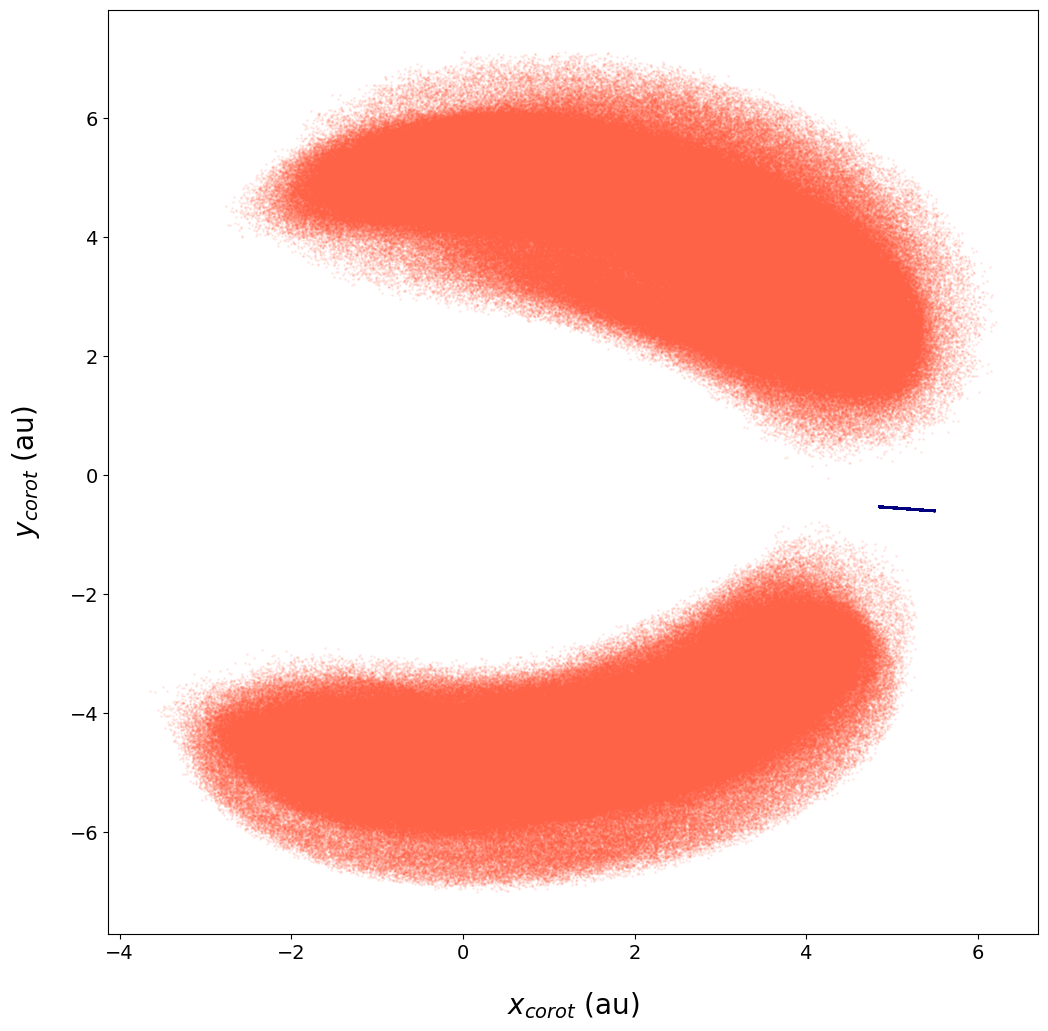

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))

for name, rock in horseshoes.items():
    tx, ty = corot(rock, planet)
    ax.scatter(tx, ty, s=1, color='black', alpha=0.1)
    
for name, rock in trojans.items():
    tx, ty = corot(rock, planet)
    ax.scatter(tx, ty, s=1, color='tomato', alpha=0.1)
    
ax.scatter(x_nep, y_nep, s=1, color='navy')


ax.set_xlabel(r'$x_{corot}$ (au)', fontsize=20, labelpad=20)
ax.set_ylabel(r'$y_{corot}$ (au)', fontsize=20, labelpad=20)
ax.tick_params(labelsize=14)

In [45]:
for name, rock in (trojans | horseshoes).items():
    rock.write_to(f'/Users/kjnapier/Desktop/fake_trojans/{name}.rocks', compression=None)
    
for name, rock in planets.groupby('name'):
    rock.write_to(f'/Users/kjnapier/Desktop/fake_trojans/{name}.rocks', compression=None)

In [35]:
len(trojans)

100